In [1]:
# Imports as always.
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from PIL import Image

from hflayers import Hopfield, HopfieldLayer, HopfieldPooling

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f'CUDA is available for use with PyTorch: {torch.cuda.is_available()}')

CUDA is available for use with PyTorch: True


In [3]:
import sys

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Installed PyTorch version: {torch.__version__}')

Installed Python version:  3.8.18
Installed PyTorch version: 2.1.2+cu121


In [4]:
# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

# Attention-like Continuous Hopfield Networks for Lesion Segmentation

Lesion segmentation is the task of identifying lesions in medical imagery. More generally, image segmentation is the task of separating objects and layers within an image. 

There are plenty of lesion segmentation benchmarks on [paperswithcode.com](https://paperswithcode.com/task/lesion-segmentation). I quite like the look of the [ISIC Challenge Datasets](https://challenge.isic-archive.com/data/#2020), which ran as a competition between 2016 to 2020. We will use the ISIC 2018 set as there are reported scores for these that we can compare our results with.

[This](https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923) might be a nice series of articles to follow.

In [5]:
# Pre-define a couple of transform functions to and from tensors and images.
tensor_to_image = transforms.ToPILImage()
image_to_tensor = transforms.ToTensor()

In [6]:
# A custom dataset object for handling the ISIC2018 data.
class ISICDataset(Dataset):
    def __init__(self, root_path, input_path, target_path):
        super(ISICDataset, self).__init__()
        
        self.root_path = root_path
        self.input_path = input_path
        self.target_path = target_path
        
        # Get a list of all the image IDs.
        pattern = re.compile(r'\d+')
        self.indices = []
        for filename in os.listdir(os.path.join(self.root_path, self.input_path)):
            matches = re.findall(pattern, filename)
            if len(matches) != 0:
                self.indices.append(int(matches[0]))
        
    def __len__(self):
        # List the inputs and target masks.
        inputs = os.listdir(os.path.join(self.root_path, self.input_path))
        targets = os.listdir(os.path.join(self.root_path, self.target_path))
        
        # Count each.
        n_inputs = len(inputs)
        n_targets = len(targets)
        
        # If these aren't the same, there's some kind of mismatch.
        assert n_inputs == n_targets, 'Mismatched number of inputs and targets.'
        
        return n_inputs
    
    def __getitem__(self, idx):
        # Translate the given idx into the corresponding image index.
        id = self.indices[idx]
        
        input_path = os.path.join(self.root_path, self.input_path, f'ISIC_{id:07d}.jpg')
        target_path = os.path.join(self.root_path, self.target_path, f'ISIC_{id:07d}_segmentation.png')
        
        input_image = image_to_tensor(Image.open(input_path))
        target_mask = image_to_tensor(Image.open(target_path))
        
        return input_image, target_mask

In [60]:
# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory, 
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth'
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory, 
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth'   
)

# Package into data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

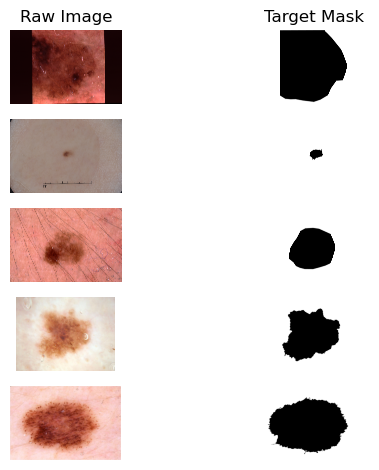

In [59]:
# Plot a few at random to see that everything looks properly set up.
n_to_plot = 5
fig, axes = plt.subplots(n_to_plot, 2, sharey='row')

for i in range(n_to_plot):
    # Sample a random example.
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    image, mask = train_dataset[sample_idx]
    
    # Plot the image and target mask.
    axes[i][0].imshow(image.permute(1, 2, 0), cmap='Greys')
    axes[i][1].imshow(mask[0], cmap='Greys')
    
    axes[i][0].axis('off')
    axes[i][1].axis('off')
    
axes[0][0].set_title('Raw Image')
axes[0][1].set_title('Target Mask')

fig.tight_layout()
plt.show()